In [1]:
import numpy as np
from tqdm.auto import tqdm
import torch
from torch import nn, einsum
import math
from inspect import isfunction
from functools import partial
from PIL import Image
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from einops import rearrange
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import Adam
from pathlib import Path
import torch.nn.functional as F

# Unetの実装

In [2]:
def exists(x):
    return x is not None

def default(val, d):
    # valがNoneでなければTrue、Noneの場合dが関数であれば呼び出した結果、関数でなければその値
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    #残差結合
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        # f(x) + x
        return self.fn(x, *args, **kwargs) + x

class UpsampleConv(nn.Module):
    #upsample用の畳み込み層
    def __init__(self, dim):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(
            in_channels=dim,
            out_channels=dim,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, x):
        return self.trans_conv(x)

class DownsampleConv(nn.Module):
    #downsample用
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=dim,
            out_channels=dim,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, x):
        return self.conv(x)

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2 # 次元の半分
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1) # conv
        self.norm = nn.GroupNorm(groups, dim_out) # normalization
        self.act = nn.SiLU() # activation
    
    def forward(self, x, scale_shift = None):
        x = self.proj(x) # 畳み込み
        x = self.norm(x) # 正規化

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        
        x = self.act(x) # 活性化関数
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, time_emb_dim = None, groups = 8):
        super().__init__()
        #時点情報time_enb
        if exists(time_emb_dim):
            self.mlp = (
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(time_emb_dim, dim_out)
                )
            )
        else:
            self.mlp = (None)

        #画像xの処理
        self.block1 = ConvBlock(dim, dim_out, groups=groups)
        self.block2 = ConvBlock(dim_out, dim_out, groups=groups)
        if dim != dim_out:
            self.res_conv = nn.Conv2d(dim, dim_out, 1)
        else:
            self.res_conv = nn.Identity()

    def forward(self, x, time_emb=None):
        # conv1
        h = self.block1(x)

        # time_embの付加
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h # バッチサイズ × チャネル数　を　バッチサイズ × チャネル数 × 1 × 1に変換

        # conv 2
        h = self.block2(h)

        # conv + 残差結合
        return h + self.res_conv(x)

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** (- 0.5) # d^(-1/2)
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1) # Q, K, Vの3つにわける
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn ,v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** (- 0.5)
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out =rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8
    ):
        super().__init__()

        self.channels = channels
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:])) # (input_dim, output_dim)というタプルのリストを作成する

        resnet_block = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            # time_mlp: pos emb -> Linear -> GELU -> Linear
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) # blockを処理する回数

        # ダウンサンプル
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
                        resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        DownsampleConv(dim_out) if not is_last else nn.Identity(),

                    ]
                )
            )

        # 中間ブロック
        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)

        # アップサンプル
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        UpsampleConv(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )
            out_dim = default(out_dim, channels)
            self.final_conv = nn.Sequential(
                resnet_block(dim, dim),
                nn.Conv2d(dim, out_dim, 1)
            )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []

        # ダウンサンプル
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # 中間
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # アップサンプル
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1) # downsampleで計算したhをくっつける
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [8]:
def extract(a, t, x_shape):
    batch_size = t.shape[0] # バッチサイズ
    out = a.gather(-1, t.cpu()) # aの最後の次元 ⇒ timestepに対応するalphaを取ってくる
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) # バッチサイズ x 1 x 1 x 1にreshape

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [9]:
timesteps = 200
betas = linear_beta_schedule(timesteps=timesteps)

# 入力テンソルの累積積(テンソルは多次元データを表す。ベクトルや行列もテンソルの一部。)
# 画像のテンソルは、幅、高さ、色情報の3つのテンソルで表現できる
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

#平均・分散を計算するため√(α¯_{t}),と1−α¯tを計算しておきます。
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) #分散

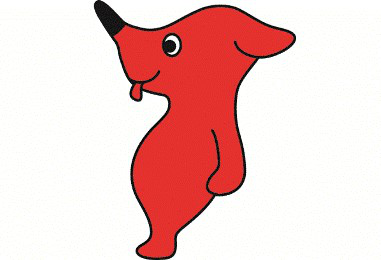

In [10]:
data = 'data/chiba.jpg'
image = Image.open(data)
image

In [11]:
# pytorchで処理するため、画像データをテンソルに変換
image_size = 128
transform = Compose([
    Resize(image_size), #サイズの縮小
    CenterCrop(image_size), #128*128にする
    ToTensor(), #テンソルにする[0,1]
    Lambda(lambda t: (t *2) - 1) #[-1,1]にする
])

# 変換後をx_start
x_start = transform(image).unsqueeze(0) # 0次元にバッチ用の次元を追加

x_start.shape

torch.Size([1, 3, 128, 128])

In [12]:
reverse_transform = Compose([
        Lambda(lambda t: (t + 1) / 2), # [-1, 1]を[0, 1]に変換
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW => HWC (チャネル、高さ、幅を高さ、幅、チャネルに変換)
        Lambda(lambda t: t * 255.), # [0, 1] ⇒ [0, 255]
        Lambda(lambda t: t.numpy().astype(np.uint8)), # 整数に変換
        ToPILImage(), # PILの画像に変換
    ])

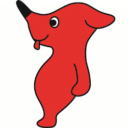

In [13]:
reverse_transform(x_start.squeeze())

In [14]:
def q_sample(x_start, t, noise=None):
    # 綺麗な画像からノイズを加えた画像をサンプリングする
    if noise is None:
        noise = torch.randn_like(x_start)

    #t時点での平均計算
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    #t時点での分散計算用
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [15]:
def get_noisy_image(x_start, t):
    x_noisy = q_sample(x_start, t) # キレイな画像にタイムステップを渡す
    #0次元目に追加したバッチ用の次元を削除
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

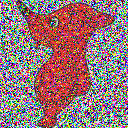

In [16]:
t = torch.tensor([40])
get_noisy_image(x_start, t)

In [17]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [18]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [19]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="huber"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.l2_loss(noise, predicted_noise)
    elif loss_type == 'huber':
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [20]:
# dataset = load_dataset("fashion_mnist")
# image_size = 28
# channels = 1
# batch_size = 128

dataset = load_dataset("sasha/dog-food")
image_size = 128
channels = 1
batch_size = 128

In [21]:
transform = Compose([
            Resize(image_size),
            CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

def transforms(examples):
    #画像データを数値データにする
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [22]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


In [23]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    #beta_t
    betas_t = extract(betas, t, x.shape)
    # 1 - √\bar{α}_t
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)

    # 1 / √α_t
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # μ_Θをモデルで求める: model(x, t)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        # σ^2_tを計算
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        # 正規乱数zをサンプリング
        noise = torch.randn_like(x)

    # x_{t-1}
    return model_mean + torch.sqrt(posterior_variance_t) * noise

#no_gradは勾配計算用のパラメータである自動微分を保存しない設定（メモリ消費削減）
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())

    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [24]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("result/generation")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    resnet_block_groups=4
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

# トレーニングの実施

In [27]:
from transformers import Trainer, TrainingArguments, TrainerCallback

class CustomCallback(TrainerCallback):
    "カスタムコールバックで特定のステップで損失を表示"
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 100 == 0:
            print(f"Step {state.global_step}, Loss: {state.log_history[-1]['loss']}")

# トレーニングの設定
training_args = TrainingArguments(
    output_dir="./results/generation",              # 出力ディレクトリ
    num_train_epochs=10,                 # トレーニングエポック数
    per_device_train_batch_size=batch_size, # バッチサイズ
    logging_steps=100,                   # ログを表示するステップ間隔
)

# Trainerの初期化
trainer = Trainer(
    model=model,                         # トレーニングするモデル
    args=training_args,                  # トレーニング引数
    train_dataset=transformed_dataset,   # トレーニングデータセット
    compute_metrics=None,                # メトリクスの計算（任意）
)

# カスタムコールバックの追加
trainer.add_callback(CustomCallback())

# トレーニングの開始
trainer.train()

# 各エポック終了時の処理（例：サンプリングと画像保存）
def on_epoch_end(args, state, control, **kwargs):
    if state.is_local_process_zero:
        samples = sample(model, image_size=image_size, batch_size=25, channels=channels)
        save_image(torch.from_numpy(samples[-1]), f'sample-{state.epoch}.png', nrow=5)

# コールバックを追加
trainer.add_callback(on_epoch_end)


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
# epochs = 10
# for epoch in range(epochs):
#     for step, batch in enumerate(dataloader):
#         optimizer.zero_grad()
#         batch_size = batch["pixel_values"].shape[0]
#         batch = batch["pixel_values"].to(device) # データを設定

#         t = torch.randint(0, timesteps, (batch_size,), device=device).long() # タイムステップ情報をバッチごとにランダムに与える
#         loss = p_losses(model, batch, t, loss_type="huber") # 画像を生成し損失を計算
#         if step % 100 == 0: # 表示
#             print("Loss", loss.item())

#         loss.backward() # 勾配の計算
#         optimizer.step() # パラメータの更新
#     samples = sample(model, image_size=image_size, batch_size=25, channels=channels)
#     save_image(torch.from_numpy(samples[-1]), str(results_folder / f'sample-{epoch}.png'), nrow=5)


In [ ]:
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

In [ ]:
for index in range(0, 63 + 1):
    plt.figure()
    plt.imshow(samples[-1][index].reshape(image_size, image_size, channels), cmap="gray")
    plt.savefig(f'result/generation/image_{index}.png')  # 画像を保存する
    plt.close()  # プロットを閉じる

In [ ]:
import matplotlib.animation as animation
random_index = 53

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()